<a href="https://colab.research.google.com/github/naman-mehta/predict_steering_angle/blob/master/selfdriving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##The model is based on https://arxiv.org/pdf/1604.07316.pdf
End to End Learning for Self-Driving Cars by Nvidia

Let's import Tensorflow 2.

In [2]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from pandas import DataFrame
import os

from tensorflow import keras




The **SullyChen's auto pilot dataset** is public and can be downloaded from this [link](https://drive.google.com/file/d/1PZWa6H0i1PCH9zuYcIh5Ouk_p-9Gh58B/view). The link is a Google drive link containing datasets of images recorded from a car dashcam with labeled steering angles.
There is data folder having images and a data.txt file with Data format is as follows: filename.jpg angle,year-mm-dd hr:min:sec:millisec.

Here I have shared it with myself by clicking on Organize in more actions. I Mount my Google Drive locally. Then I copy the zipped dataset here which takes around two minutes. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/My\ Drive/07012018.zip /content/dataset.zip

Now let's unzip the datset.

In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

Just checking the number of images.

In [4]:
%cd /content/dataset/data
!ls -1 | wc -l


/content/dataset/data
63825


Here contents are the number of rows in or labels in data.txt file. So there are no missing labels.

In [5]:
data_dir="/content/dataset/"
with open( data_dir+'data.txt', 'r') as f:
  contents=f.read()
  
contents= list(contents.split('\n'))  
del contents[-1]
print("Total size of dataset {:,} images".format(len(contents)))

TOTAL_SIZE_DATASET=len(contents)


Total size of dataset 63,825 images


To construct a TF Dataset from data in memory, we can use tf.data.Dataset.from_tensor_slices()

In [6]:
dataset = tf.data.Dataset.from_tensor_slices(contents)
print(dataset.element_spec)


TensorSpec(shape=(), dtype=tf.string, name=None)


The Dataset.map(f) transformation produces a new dataset by applying a given function f to each element of the input dataset. Multiple images are loaded/processed in parallel.
For performance reasons, use TensorFlow operations for preprocessing your data whenever possible. 


A short function that converts a file path to an (img, label) pair:

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
"""code with tensorflow tf.data.dataset"""
IMG_WIDTH=66
IMG_HEIGHT=200


#get label function returns label  
def get_label(file_path):
  #It takes out angle which is the second element in string 
  label_in_string = tf.strings.split(tf.strings.split(file_path, ',')[0],' ')[1]
  label_in_degree = tf.strings.to_number(label_in_string)
  pi_on_180 = 0.017453292519943295
  #convert it to radian and return 
  return tf.math.multiply(label_in_degree,pi_on_180)

#decode_img functions returns the resized image 
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

#process_path function returns image and label together
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(data_dir+'data/'+ tf.strings.split(file_path, ' ')[0])
  img = decode_img(img)
  return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = dataset.map(process_path,num_parallel_calls=AUTOTUNE)
#Dataset.element_spec property allows us to inspect the type of each element component
print("Tensor specification",labeled_ds.element_spec)

#print the shape and angle of 1st image in dataset
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  
#WE CAN SPLIT THE DATASET HERE INTO TRAIN VAL AND TEST OR DURING CALL FOR TRAINING  
#split the TRAINING and TEST dataset in 80:20 ratio
train_val = labeled_ds.take(int(TOTAL_SIZE_DATASET*0.8))
test = labeled_ds.skip(int(TOTAL_SIZE_DATASET*0.8))

#split further the TRAIN and VAL dataset in 80:20 ratio
train = train_val.take(int(len(train_val)*0.8))
val = train_val.skip(int(len(train_val)*0.8))

print("Size of training set is {0}, Validation set is {1}, Test set is {2}".format(len(train),len(val),len(test)))

Tensor specification (TensorSpec(shape=(66, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))
Image shape:  (66, 200, 3)
Label:  0.0
Size of training set is 40848, Validation set is 10212, Test set is 12765


**Dataset Exploration**
However, upon analysing the steering angles captured across our datasets, we quickly realised we had a problem: the data is greatly imbalanced, with an overwhelming number of steering wheel data being neutral (i.e. 0). This means, that unless we take corrective measures, our model will be biased to driving straight.

Convert contents to tensorflow dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed64dd6a90>]],
      dtype=object)

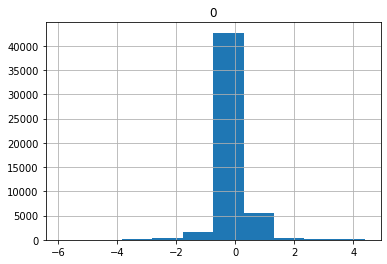

In [ ]:
labels_list= []
for image, label in train.as_numpy_iterator():
  labels_list.append(label)
df = DataFrame(labels_list) 
DataFrame.hist(df,bins=10)

Most of the the dataset show the car driving with a neutral steering wheel angle so with this dataset our model would tend to drive itself in a straight line.

**Dataset Augmentation**

Here I try to augment the training dataset with images which don't have nuetral steering angle.
So goal is to get a balanced dataset.

In [8]:
import cv2
import numpy as np

########## Image Manipulation Functions ##########

def flip_image(img):
    """
    Returns a horizontally flipped image
    """
    return cv2.flip(img, 1)


def change_image_brightness_rgb(img, s_low=0.2, s_high=0.75):
    """
    Changes the image brightness by multiplying all RGB values by the same scalacar in [s_low, s_high).
    Returns the brightness adjusted image in RGB format.
    """
    img = img.astype(np.float32)
    s = np.random.uniform(s_low, s_high)
    img[:,:,:] *= s
    np.clip(img, 0, 255)
    return  img.astype(np.uint8)

# Read more about it here: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
def translate_image(img, st_angle, low_x_range, high_x_range, low_y_range, high_y_range, delta_st_angle_per_px):
    """
    Shifts the image right, left, up or down. 
    When performing a lateral shift, a delta proportional to the pixel shifts is added to the current steering angle 
    """
    rows, cols = (img.shape[0], img.shape[1])
    translation_x = np.random.randint(low_x_range, high_x_range) 
    translation_y = np.random.randint(low_y_range, high_y_range) 
    
    st_angle += translation_x * delta_st_angle_per_px

    translation_matrix = np.float16([[1, 0, translation_x],[0, 1, translation_y]])
    img = cv2.warpAffine(img, translation_matrix, (cols, rows))
    
    return img, st_angle



########## Data Augmentation Function ##########

def augment_image(img, st_angle, p=1.0):
    """
    Augment a given image, by applying a series of transformations, with a probability p.
    The steering angle may also be modified.
    Returns the tuple (augmented_image, new_steering_angle)
    """
    aug_img = img
    
    if np.random.random_sample() <= p: 
        # Horizontally flip image
        aug_img = flip_image(aug_img)
        st_angle = -st_angle
     
    if np.random.random_sample() <= p:
        aug_img = change_image_brightness_rgb(aug_img)
    

    #if np.random.random_sample() <= p:
        # Shift the image left/right, up/down and modify the steering angle accordingly
        #aug_img, st_angle = translate_image(aug_img, st_angle, -60, 61, -20, 21, 0.35/100.0)
    
    # TODO In the future try adding slight rotations
        
    return aug_img, st_angle

In [9]:
st_angle_threshold=0.05
nuetral_angle_remove=0.1
neutral_drop=0.5
train_augmented = []
for data in train.as_numpy_iterator():
  #we want to drop some nuetral steering angles.
  if abs(label) < nuetral_angle_remove and np.random.random_sample() < neutral_drop:
    continue
  train_augmented.append(data)  
  image,label = data
  if abs(label) < st_angle_threshold:
    continue
  image_aug,label_aug = augment_image(image, label, p = 0.5)  
  data_aug= image_aug,label_aug
  train_augmented.append(data_aug)

In [10]:
print("Training dataset size is changed from {} to {}" .format(len(train),len(train_augmented)))

Training dataset size is changed from 40848 to 55817


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa50f2672b0>]],
      dtype=object)

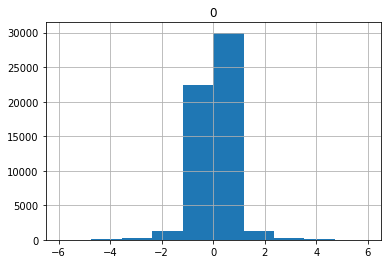

In [11]:
labels_list_aug= []
image_list_aug= []
for image, label in train_augmented:
  image_list_aug.append(image)
  labels_list_aug.append(label)
df_aug = DataFrame(labels_list_aug) 
DataFrame.hist(df_aug,bins=10)

Not able to load whole dataset in colab. So will try to train on part of the dataset. Otherwise you will get a error that your execution crashed after utilising whole RAM.

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((image_list_aug[:10000],labels_list_aug[:10000]))

Configure the dataset for performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

.prefetch() overlaps data preprocessing and model execution while training.

.repeat() can specify the number of times we want the dataset to be iterated. If no parameter is passed it will loop forever, usually is good to just loop forever and directly control the number of epochs with a standard loop.

.shuffle() shuffles the dataset by default every epoch.
Remember: shuffle the dataset is very important to avoid overfitting.

A Batch of Training Dataset


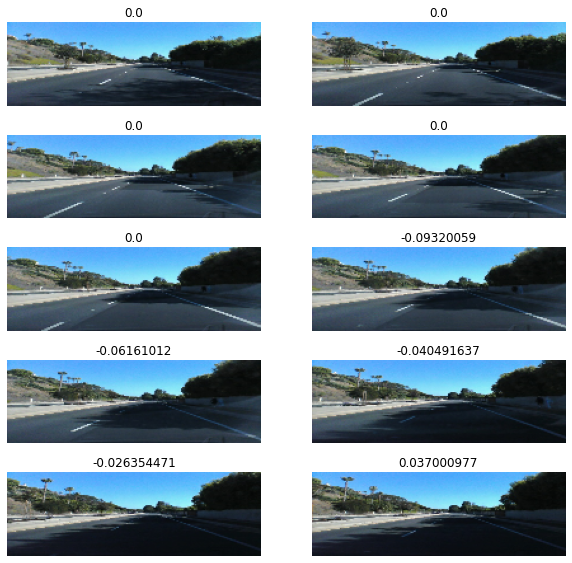

In [21]:
#repeat and batch. Inspect a batch.
EPOCHS = 30
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE


def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
      ax = plt.subplot(5,2,n+1)
      i=(n+n*2)%64
      plt.imshow(image_batch[i])
      plt.title(label_batch[i])
      plt.axis('off')

def tf_data_augmentation(image,label):
  flipped = tf.image.flip_left_right(image)
  label = tf.math.negative(label)
  return flipped, label

def prepare_for_training(ds, augment=False, shuffle=False, cache=True):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # Repeat forever
    # Use data augmentation only on the training set
  # if augment:
  #   ds = ds.map(tf_data_augmentation, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)
  if shuffle:
    ds.shuffle(100)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

print("A Batch of Training Dataset")
#train_ds = tf.data.Dataset.from_tensor_slices(train_augmented)
train_ds = prepare_for_training(train_ds, shuffle = True, cache = False)
train_images, train_labels = next(iter(train_ds))
show_batch(train_images.numpy(), train_labels.numpy())

val_ds = prepare_for_training(val, shuffle = True)

test_ds = prepare_for_training(test)







In [22]:
import time
default_timeit_steps = 5

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [23]:
timeit(train_ds)

.
5 batches: 1.3913309574127197 s
229.99560 Images/s


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization

model = Sequential([
    # We have a series of 3 5x5 convolutional layers with a stride of 2x2
    Conv2D(filters=24,kernel_size = 5,strides=(2, 2),activation='relu',input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    BatchNormalization(),

    Conv2D(filters=36,kernel_size = 5,strides=(2, 2),activation='relu'),
    BatchNormalization(),
   
    Conv2D(filters=48,kernel_size = 5,strides=(2, 2),activation='relu'),
    BatchNormalization(),

    
    # This is then followed by 2 3x3 convolutional layers with a 1x1 stride
    
    Conv2D(filters=64,kernel_size = 3,strides=(1, 1),activation='relu'),
    BatchNormalization(),
    
    Conv2D(filters=64,kernel_size = 3,strides=(1, 1),activation='relu'),
    BatchNormalization(),
    
    # Flattening the output of last convolutional layer before entering fully connected phase
    Flatten(),
    
    # Fully connected layers
    Dense(1164, activation='relu'),
    BatchNormalization(),
    
    Dense(200, activation='relu'),
    BatchNormalization(),
    
    Dense(50, activation='relu'),
    BatchNormalization(),
    
    Dense(10, activation='relu'),
    BatchNormalization(),
   
    # Output layer
    Dense(1)
    
])    

   
    
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=['mae', 'mse'])
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 98, 24)        96        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 47, 36)        144       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 22, 48)         192       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         2

In [26]:
import os
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/training_checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True, 
    verbose=1, 
    save_weights_only=True,
    period=10)

#check this is not required
# # Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=0))



In [ ]:
history = model.fit(train_ds,
                    steps_per_epoch = len(train_val)*0.8 // BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data = val_ds,
                    validation_steps = len(train_val)*0.2 // BATCH_SIZE,
                    callbacks=[cp_callback],
                    shuffle=True)

Epoch 1/30
157/638 [======>.......................] - ETA: 10s - loss: 0.2939 - mae: 0.3910 - mse: 0.2939WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 19140.0 batches). You may need to use the repeat() function when building your dataset.


In [ ]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
eval_loss, eval_mae, eval_mse = model.evaluate(test_ds, verbose=2, steps = (len(test_ds)) // BATCH_SIZE)

print('Eval loss: {}, Eval Accuracy: {}'.format(eval_loss, eval_mae))

127/127 - 1s - loss: 0.0887 - mae: 0.1389 - mse: 0.0887
Eval loss: 0.0886788268362293, Eval Accuracy: 0.1389133781194687


In [ ]:
path = "/content/model"
model.save(path, save_format='tf')

INFO:tensorflow:Assets written to: /content/model/assets


Let us visualise the results after training the network.

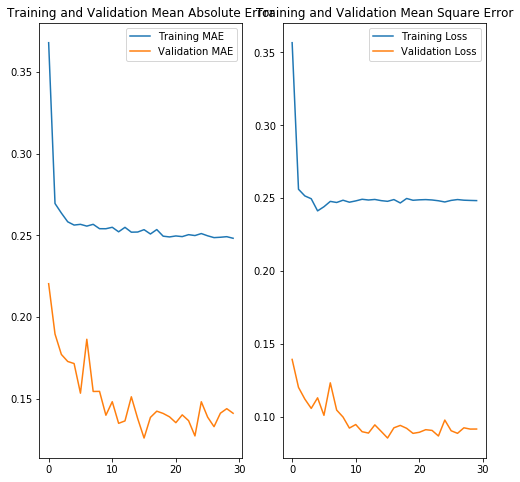

In [ ]:
# epochs=10
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label='Training MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.title('Training and Validation Mean Absolute Error')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Mean Square Error')
plt.show()

In [ ]:
!zip -r /content/model.zip /content/model

In [ ]:
from google.colab import files
files.download("/content/model.zip")